## Example: Coin toss model (Beta-Bernoulli)

In this example, we are going to perform an exact inference for a coin toss model that can be represented as:

$$
\begin{equation}
\begin{aligned}
p(\theta) &= \mathrm{Beta}(\theta|a, b),\\
p(y_i|\theta) &= \mathrm{Ber}(y_i|\theta),\\
\end{aligned}
\end{equation}
$$

where $y_i \in \{0, 1\}$ is a binary observation induced by Bernoulli likelihood while $\theta$ is a Beta prior distribution on the parameter of Bernoulli.
We are interested in inferring the posterior distribution of $\theta$.

We start with importing all needed packages:

In [1]:
using Rocket, GraphPPL, ReactiveMP, Distributions, Random

┌ Info: Precompiling ReactiveMP [a194aa59-28ba-4574-a09c-4a745416d6e3]
└ @ Base loading.jl:1423


In [2]:
rng = MersenneTwister(42)
n = 500
θ_real = 0.75
distribution = Bernoulli(θ_real)

dataset = float.(rand(rng, Bernoulli(θ_real), n));

In [3]:
# GraphPPL.jl export `@model` macro for model specification
# It accepts a regular Julia function and builds an FFG under the hood
@model function coin_model(n)

    # `datavar` creates data 'inputs' in our model
    # We will pass data later on to these inputs
    # In this example we create a sequence of inputs that accepts Float64
    y = datavar(Float64, n)

    # We endow θ parameter of our model with some prior
    θ ~ Beta(2.0, 7.0)

    # We assume that outcome of each coin flip is governed by the Bernoulli distribution
    for i in 1:n
        y[i] ~ Bernoulli(θ)
    end

    # We return references to our data inputs and θ parameter
    # We will use these references later on during inference step
    return y, θ
end

In [4]:
result = inference(
    model = Model(coin_model, length(dataset)), 
    data  = (y = dataset, )
)

Inference results:
-----------------------------------------
θ = Marginal[Marginal(Beta{Float64}(α=363.0, β=146.0)


In [5]:
θestimated = result.posteriors[:θ][end]

Marginal(Beta{Float64}(α=363.0, β=146.0))

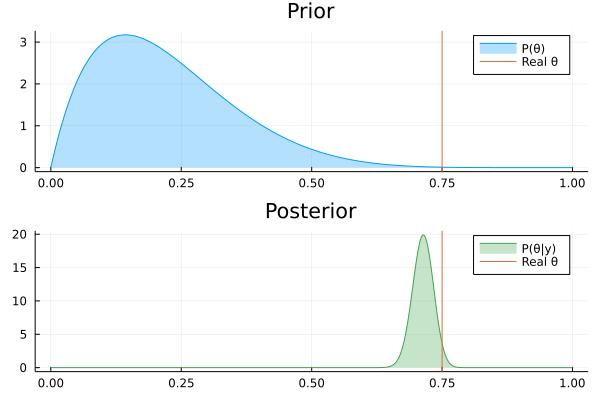

In [6]:
using Plots, LaTeXStrings; theme(:default)

rθ = range(0, 1, length = 1000)

p1 = plot(rθ, (x) -> pdf(Beta(2.0, 7.0), x), title="Prior", fillalpha=0.3, fillrange = 0, label="P(θ)", c=1,)
vline!([θ_real], label="Real θ")
p2 = plot(rθ, (x) -> pdf(θestimated, x), title="Posterior", fillalpha=0.3, fillrange = 0, label="P(θ|y)", c=3)
vline!([θ_real],  label="Real θ")

p_ = plot(p1, p2, layout = @layout([ a; b ]))